### Import libraries

In [378]:
from pprint import pprint
import time
import joblib
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, KFold, cross_validate, StratifiedKFold 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')

### Data Loading and Exploration

In [331]:
with open('emails.txt','r') as file:
    lines = file.readlines()

data = [line.strip() for line in lines]
print(data)

['Elody_OConner51@gmail.com', 'lily.long85@yahoo.com', 'simon.ward@protonmailcom', 'benjamin.phillips@hotmail.com', 'robert.walker@aol.com', 'samantha_turner1987@gmail.com', 'matthew7843@icloud.com', 'matthew.lewis@gmail,', 'Jerrod_Considine79@yahoo.com', 'Beverly_Renner@outlook.com', 'smith.kelly1996@aol.com', 'michael.kane1986@hotmail.com', 'Dock_King@yahoo.com', 'Elmo_Weissnat@mail.com', 'Nils_Pacocha24@tutanota.com', 'claire_harris9987@outlook.com', 'peter.jackson@aol,', 'paul.baker@aolcom', 'Maiya.Huel47@aol.com', 'zoe1983_barnes@aol.com', 'Jaclyn.Littel@aol.com', 'mary.green@yahoo.com', 'mandy.04@gmail.com', 'laura.foster@icloud..com', 'jessica.evans04@gmail.com', 'nathan.james95@outlook.com', 'Raina.OHara70@outlook.com', 'luke_barnes2006@gmail.com', 'nathan.brooks@icloud,com', 'matthew.roberts@protonmail.com', 'susan.brown@gmail.com', 'natalie9872_smith@yahoo.com', 'peter.ward@gmail.com', 'rebecca.thomas@hotmail.com', 'amelia.simmons@yahoo,', 'carter85_burn@hotmail.com', 'amanda

In [332]:
print(f"No of emails/data elements = {len(data)}")

No of emails/data elements = 1073


In [333]:
# find all email domain names
email_domains = {}
for email in data:
    domain = re.findall(r'(?<=@)[^@]+$',email)[0]
    if domain not in email_domains.keys():
        email_domains[domain] = 1
    else:
        email_domains[domain] += 1

In [334]:
email_domains

{'gmail.com': 355,
 'yahoo.com': 110,
 'protonmailcom': 5,
 'hotmail.com': 75,
 'aol.com': 91,
 'icloud.com': 80,
 'gmail,': 2,
 'outlook.com': 99,
 'mail.com': 36,
 'tutanota.com': 48,
 'aol,': 1,
 'aolcom': 4,
 'icloud..com': 2,
 'icloud,com': 2,
 'protonmail.com': 101,
 'yahoo,': 3,
 'hotmail,com': 1,
 'icloud..': 2,
 'yahoo': 1,
 'organization.org': 1,
 'college.edu': 2,
 'yahoo,com': 3,
 'mail.service.com': 2,
 'com': 2,
 'gmail': 1,
 'icloud': 1,
 'sub.company.com': 1,
 'outlookcom': 2,
 'company.co.uk': 2,
 'gmail,com': 5,
 'hotmail,': 1,
 'outlook..': 2,
 'yahoo..com': 1,
 'sub.domain.com': 2,
 'aol,com': 1,
 'protonmail..com': 1,
 'hotmailcom': 8,
 'gmailcom': 4,
 'outlook,': 3,
 'protonmail': 1,
 'yahoo.': 1,
 'outlook': 1,
 'icloud,': 3,
 'protonmail,.com': 1,
 'protonmail,com': 2,
 'outlook..com': 1}

In [335]:
# standardizing domain names
for i in range(len(data)):
    data[i] = re.sub(r'proton\S*','protonmail.com',data[i])
    data[i] = re.sub(r'icloud\S*','icloud.com',data[i])
    data[i] = re.sub(r'outlook\S*','outlook.com',data[i])
    data[i] = re.sub(r'gmail\S*','gmail.com',data[i])
    data[i] = re.sub(r'aol\S*','aol.com',data[i])
    data[i] = re.sub(r'yahoo\S*','yahoo.com',data[i])
    data[i] = re.sub(r'hotmail\S*','hotmail.com',data[i])
    

In [336]:
# recreating all standardized email domains as a dictionary
email_domains = {}
for email in data:
    domain = re.findall(r'(?<=@)[^@]+$',email)[0]
    if domain not in email_domains.keys():
        email_domains[domain] = 1
    else:
        email_domains[domain] += 1

In [337]:
email_domains

{'gmail.com': 368,
 'yahoo.com': 119,
 'protonmail.com': 112,
 'hotmail.com': 85,
 'aol.com': 97,
 'icloud.com': 90,
 'outlook.com': 108,
 'mail.com': 36,
 'tutanota.com': 48,
 'organization.org': 1,
 'college.edu': 2,
 'mail.service.com': 2,
 'sub.company.com': 1,
 'company.co.uk': 2,
 'sub.domain.com': 2}

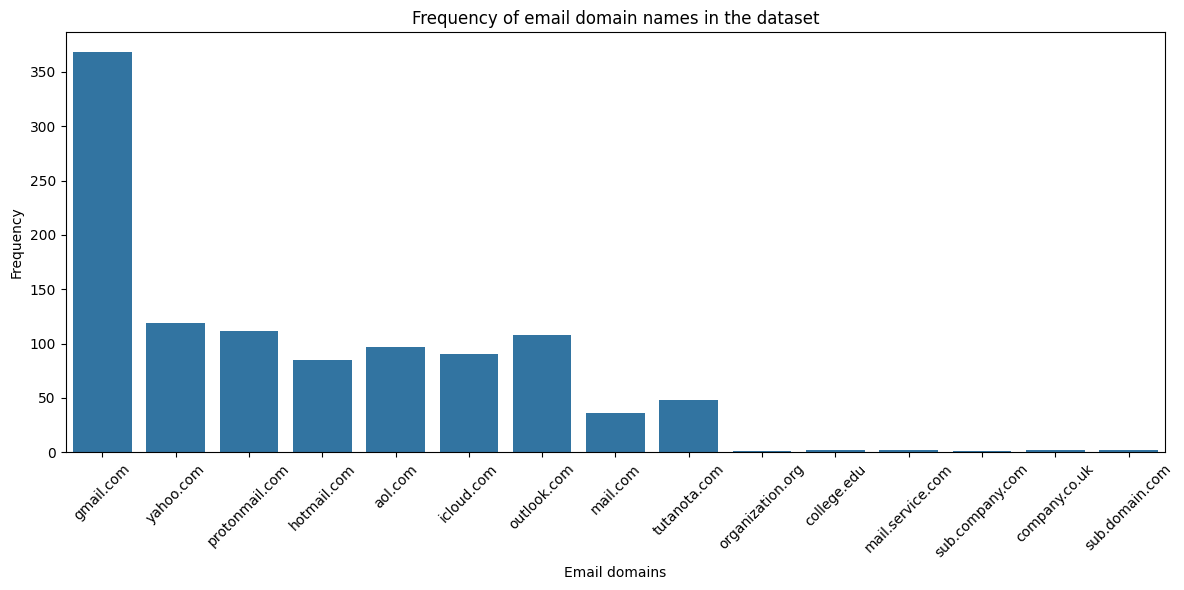

In [338]:
plt.figure(figsize=(12,6))
plt.xticks(rotation=45)
sns.barplot(email_domains)
plt.xlabel('Email domains')
plt.ylabel('Frequency')
plt.title('Frequency of email domain names in the dataset')
plt.tight_layout()
plt.show()

### Assumptions
The dataset (emails.txt) has no information on actual age of an email holder, so to be able to resolve this problem using machine learning, we need feature engineer features based on the email address and also set target feature 'age' based on some assumptions (not too absurd).

The main idea is we leverage email domain names and digits in the email address to create a sensible target feature. Meanwhile other features like length of username and inclusion of special characters which seem to have indirect link to target feature would be included in training machine learning models. And, leverage ML model to find a pattern from those features too.


- If an email address has a 4/2 digits, which seems like a valid year then, we use that date to bag it into one of the age groups.
- Email domain names could also provide some information on the age group of an email holder.
 - aol.com was popular in 1990s, meaning we could assume that an email address with that domain indicates an old age group.
 - icloud.com, protonMail.com, tutanota.com are email domains which were founded after 2010s, so it wouldn't be too absurd assumption, if we set target feature 'age' as young for email addresses with those domains.
 - mail.com is a special email domain which has a functionality of custom domain name. It came out in 1995 and is popular among business owners and 'medium' age group has more money and experience for owning businesses and tech-friendlier than 'old' age group, so we can set email addresses of this domain to 'medium' age group.

In [339]:
username_lengths = []
domains = []
has_underscores = []
has_periods = []
digits = []
ages = ['not_sure']*len(data)
has_digits = []

In [340]:

for i in range(len(data)):
    # username and domain split
    result = data[i].split('@')
    # extract domain name
    domains.append(result[-1])
    # check if an email has a digit
    has_digits.append(bool(re.search(r'\d',data[i])))
    # check if the email has underscore/period special character in the username 
    username = result[0]
    username_lengths.append(len(username))
    has_underscores.append(bool(re.search(r'[_]',username)))
    has_periods.append(bool(re.search(r'[.]',username)))
    # extract digits
    digit = re.findall(r'\d+',data[i])
    if len(digit) > 0:
        digits.append(digit[0])
    else:
        digits.append(0)
    # for emails having 4 digits
    match = re.findall(r'\d{4}',data[i])
    if len(match)>0:
        year = int(match[0])
        if (1994 <= year <= 2006):
            ages[i] = 'young'
        elif (1974 <= year < 1994):
            ages[i] = 'medium'
        elif (1950 <= year < 1974):
            ages[i] = 'old'
        continue

    # for emails having exactly 2 digits
    match = re.findall(r'(?<!\d)\d{2}(?!\d)',data[i])
    if len(match)>0:
        year = int(match[0])
        if ((0 <= year <= 6) or (94 <= year <= 99)):
            ages[i] = 'young'
        elif (74 <= year < 94):
            ages[i] = 'medium'
        elif (50 <= year < 74):
            ages[i] = 'old'
    

In [341]:
df = pd.DataFrame(
    {'email':data,'digits':digits,'age':ages,'has_digit':has_digits,'has_underscore':has_underscores,
     'has_period':has_periods, 'username_length':username_lengths, 'domain':domains})
df.head(20)

,email,digits,age,has_digit,has_underscore,has_period,username_length,domain
0,Elody_OConner51@gmail.com,51,old,True,True,False,15,gmail.com
1,lily.long85@yahoo.com,85,medium,True,False,True,11,yahoo.com
2,simon.ward@protonmail.com,0,not_sure,False,False,True,10,protonmail.com
3,benjamin.phillips@hotmail.com,0,not_sure,False,False,True,17,hotmail.com
4,robert.walker@aol.com,0,not_sure,False,False,True,13,aol.com
5,samantha_turner1987@gmail.com,1987,medium,True,True,False,19,gmail.com
6,matthew7843@icloud.com,7843,not_sure,True,False,False,11,icloud.com
7,matthew.lewis@gmail.com,0,not_sure,False,False,True,13,gmail.com
8,Jerrod_Considine79@yahoo.com,79,medium,True,True,False,18,yahoo.com
9,Beverly_Renner@outlook.com,0,not_sure,False,True,False,14,outlook.com


In [342]:
### Domains which have significantly less no of instances are grouped to others
df.loc[df['domain'].isin(('college.edu','mail.service.com','company.co.uk','sub.domain.com','organization.org','sub.company.com')),'domain'] = 'others'

In [343]:
# email addresses belonging to some domains, we assume and group them into some age group 
df.loc[(df['age'] == 'not_sure') & (df['domain'] == 'aol.com'), 'age'] = 'old'
df.loc[(df['age'] == 'not_sure') & (df['domain']=='mail.com'),'age'] = 'medium'
df.loc[(df['age'] == 'not_sure') & (df['domain'].isin(('icloud.com','protonmail.com','tutanota.com'))),'age'] = 'young'

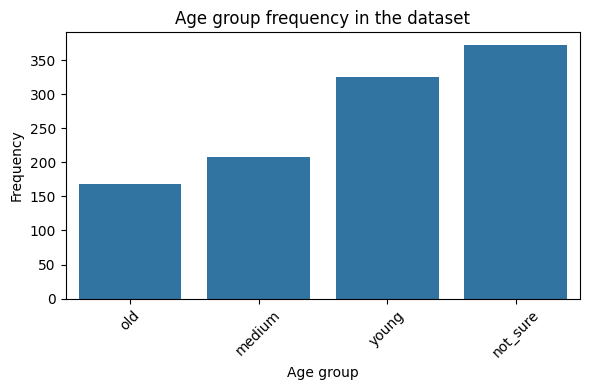

In [344]:
plt.figure(figsize=(6,4))
plt.xticks(rotation=45)
sns.countplot(data=df,x='age')
plt.xlabel('Age group')
plt.ylabel('Frequency')
plt.title('Age group frequency in the dataset')
plt.tight_layout()
plt.show()

###  Encoding of the features

- To be able to train the machine learning models, we need to encode features into suitable format

In [345]:
df.loc[(df['age'] == 'young'),'age'] = 0
df.loc[(df['age'] == 'medium'),'age'] = 1
df.loc[(df['age'] == 'old'),'age'] = 2
df.loc[(df['age'] == 'not_sure'),'age'] = 3

In [346]:
# create categorical dummy encodings for 'domain' feature
new_df = pd.get_dummies(df, columns=['domain'])
new_df.head()

,email,digits,age,has_digit,has_underscore,has_period,username_length,domain_aol.com,domain_gmail.com,domain_hotmail.com,domain_icloud.com,domain_mail.com,domain_others,domain_outlook.com,domain_protonmail.com,domain_tutanota.com,domain_yahoo.com
0,Elody_OConner51@gmail.com,51,2,True,True,False,15,False,True,False,False,False,False,False,False,False,False
1,lily.long85@yahoo.com,85,1,True,False,True,11,False,False,False,False,False,False,False,False,False,True
2,simon.ward@protonmail.com,0,0,False,False,True,10,False,False,False,False,False,False,False,True,False,False
3,benjamin.phillips@hotmail.com,0,3,False,False,True,17,False,False,True,False,False,False,False,False,False,False
4,robert.walker@aol.com,0,2,False,False,True,13,True,False,False,False,False,False,False,False,False,False


In [347]:
# converting True to 1 and False to 0 for all features
new_df = new_df.replace({True:1, False:0})
new_df.head()

,email,digits,age,has_digit,has_underscore,has_period,username_length,domain_aol.com,domain_gmail.com,domain_hotmail.com,domain_icloud.com,domain_mail.com,domain_others,domain_outlook.com,domain_protonmail.com,domain_tutanota.com,domain_yahoo.com
0,Elody_OConner51@gmail.com,51,2,1,1,0,15,0,1,0,0,0,0,0,0,0,0
1,lily.long85@yahoo.com,85,1,1,0,1,11,0,0,0,0,0,0,0,0,0,1
2,simon.ward@protonmail.com,0,0,0,0,1,10,0,0,0,0,0,0,0,1,0,0
3,benjamin.phillips@hotmail.com,0,3,0,0,1,17,0,0,1,0,0,0,0,0,0,0
4,robert.walker@aol.com,0,2,0,0,1,13,1,0,0,0,0,0,0,0,0,0


In [348]:
def get_first_name(value):
    """
        Function to get the first name of the username assuming the every email address first name is present and 
        at some location.
        Args:
            - value(string): email address

        Returns:
            - string
    """
    username = value.split('@')[0]
    if bool(re.search(r'[_]',username)):
        return username.split('_')[0]
    elif bool(re.search(r'[.]',username)):
        return username.split('.')[0]
    
    return username


In [349]:
new_df['first_name'] = new_df['email'].apply(get_first_name) 

In [350]:
new_df.head()

,email,digits,age,has_digit,has_underscore,has_period,username_length,domain_aol.com,domain_gmail.com,domain_hotmail.com,domain_icloud.com,domain_mail.com,domain_others,domain_outlook.com,domain_protonmail.com,domain_tutanota.com,domain_yahoo.com,first_name
0,Elody_OConner51@gmail.com,51,2,1,1,0,15,0,1,0,0,0,0,0,0,0,0,Elody
1,lily.long85@yahoo.com,85,1,1,0,1,11,0,0,0,0,0,0,0,0,0,1,lily
2,simon.ward@protonmail.com,0,0,0,0,1,10,0,0,0,0,0,0,0,1,0,0,simon
3,benjamin.phillips@hotmail.com,0,3,0,0,1,17,0,0,1,0,0,0,0,0,0,0,benjamin
4,robert.walker@aol.com,0,2,0,0,1,13,1,0,0,0,0,0,0,0,0,0,robert


In [351]:
new_df.isna().sum()

email                    0
digits                   0
age                      0
has_digit                0
has_underscore           0
has_period               0
username_length          0
domain_aol.com           0
domain_gmail.com         0
domain_hotmail.com       0
domain_icloud.com        0
domain_mail.com          0
domain_others            0
domain_outlook.com       0
domain_protonmail.com    0
domain_tutanota.com      0
domain_yahoo.com         0
first_name               0
dtype: int64

In [353]:
new_df.head()

,email,digits,age,has_digit,has_underscore,has_period,username_length,domain_aol.com,domain_gmail.com,domain_hotmail.com,domain_icloud.com,domain_mail.com,domain_others,domain_outlook.com,domain_protonmail.com,domain_tutanota.com,domain_yahoo.com,first_name
0,Elody_OConner51@gmail.com,51,2,1,1,0,15,0,1,0,0,0,0,0,0,0,0,Elody
1,lily.long85@yahoo.com,85,1,1,0,1,11,0,0,0,0,0,0,0,0,0,1,lily
2,simon.ward@protonmail.com,0,0,0,0,1,10,0,0,0,0,0,0,0,1,0,0,simon
3,benjamin.phillips@hotmail.com,0,3,0,0,1,17,0,0,1,0,0,0,0,0,0,0,benjamin
4,robert.walker@aol.com,0,2,0,0,1,13,1,0,0,0,0,0,0,0,0,0,robert


### Splitting of the data before scaling and training machine learning models on them

In [354]:
new_df.columns

Index(['email', 'digits', 'age', 'has_digit', 'has_underscore', 'has_period',
       'username_length', 'domain_aol.com', 'domain_gmail.com',
       'domain_hotmail.com', 'domain_icloud.com', 'domain_mail.com',
       'domain_others', 'domain_outlook.com', 'domain_protonmail.com',
       'domain_tutanota.com', 'domain_yahoo.com', 'first_name'],
      dtype='object')

In [356]:
X = new_df[['digits', 'has_digit', 'has_underscore', 'has_period',
       'username_length', 'domain_aol.com', 'domain_gmail.com',
       'domain_hotmail.com', 'domain_icloud.com', 'domain_mail.com',
       'domain_others', 'domain_outlook.com', 'domain_protonmail.com',
       'domain_tutanota.com', 'domain_yahoo.com']]
y = new_df['age']

In [357]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42,shuffle=True)

In [358]:
len(X_train), len(X_test)

(858, 215)

### Standard scaling of continous numerical independent features

- Scaling would be done based on training data and the X_test features would be scaled using it.

In [359]:
X_train.head()

,digits,has_digit,has_underscore,has_period,username_length,domain_aol.com,domain_gmail.com,domain_hotmail.com,domain_icloud.com,domain_mail.com,domain_others,domain_outlook.com,domain_protonmail.com,domain_tutanota.com,domain_yahoo.com
917,1986,1,1,0,15,0,1,0,0,0,0,0,0,0,0
293,15,1,1,0,16,0,0,0,0,0,0,0,1,0,0
471,42,1,0,0,6,0,0,0,0,1,0,0,0,0,0
64,71,1,0,0,10,0,0,0,0,0,0,1,0,0,0
873,66,1,1,0,19,0,0,0,0,0,0,1,0,0,0


In [360]:
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

In [361]:
scaler = StandardScaler()
X_train_scaled[['digits','username_length']] = scaler.fit_transform(X_train_scaled[['digits','username_length']])

In [401]:
# store the trained standard scaler for inference later  
joblib.dump(scaler,'standard_scaler.joblib')

['standard_scaler.joblib']

In [362]:
X_train_scaled.head()

,digits,has_digit,has_underscore,has_period,username_length,domain_aol.com,domain_gmail.com,domain_hotmail.com,domain_icloud.com,domain_mail.com,domain_others,domain_outlook.com,domain_protonmail.com,domain_tutanota.com,domain_yahoo.com
917,0.210072,1,1,0,0.454589,0,1,0,0,0,0,0,0,0,0
293,-0.208296,1,1,0,0.752555,0,0,0,0,0,0,0,1,0,0
471,-0.202565,1,0,0,-2.227104,0,0,0,0,1,0,0,0,0,0
64,-0.196409,1,0,0,-1.035241,0,0,0,0,0,0,1,0,0,0
873,-0.197471,1,1,0,1.646453,0,0,0,0,0,0,1,0,0,0


In [363]:
X_test_scaled[['digits','username_length']] = scaler.transform(X_test_scaled[['digits','username_length']])

In [364]:
X_test_scaled.head()

,digits,has_digit,has_underscore,has_period,username_length,domain_aol.com,domain_gmail.com,domain_hotmail.com,domain_icloud.com,domain_mail.com,domain_others,domain_outlook.com,domain_protonmail.com,domain_tutanota.com,domain_yahoo.com
558,-0.211480,0,0,1,-0.141343,0,0,1,0,0,0,0,0,0,0
489,0.150427,1,0,1,1.050521,0,1,0,0,0,0,0,0,0,0
307,-0.202140,1,0,0,-1.333207,0,0,0,0,0,0,1,0,0,0
579,-0.211480,0,1,0,-1.631173,0,1,0,0,0,0,0,0,0,0
582,-0.211480,0,0,1,-0.737275,0,0,0,0,0,0,0,1,0,0


In [298]:
X_test.columns

Index(['digits', 'has_digit', 'has_underscore', 'has_period',
       'username_length', 'domain_aol.com', 'domain_gmail.com',
       'domain_hotmail.com', 'domain_icloud.com', 'domain_mail.com',
       'domain_others', 'domain_outlook.com', 'domain_protonmail.com',
       'domain_tutanota.com', 'domain_yahoo.com'],
      dtype='object')

### First impression with baseline machine learning classifier (logistic regression)

In [367]:
model = LogisticRegression(multi_class='multinomial')
model.fit(X_train_scaled,y_train)

LogisticRegression(multi_class='multinomial')

In [368]:
y_pred = model.predict(X_test_scaled)
print(f"Accuracy on test_data = {balanced_accuracy_score(y_test,y_pred)}")

Accuracy on test_data = 0.6402448505389682


### Training with KNN, Decision Tree, Random Forest
- These are some of the popular algorithms and worth to train and evaluate their performance
- There are many hyperparameters that needs to be tuned in these algorithms to get their best performance but tuning all of them might be out of scope due to limited processing power and time.
- So, we shall tune some of the most common parameters for them. There's a wide possibility of range of values that can be given to hyperparameters, so first of all, we will test the performance of the models on a diverse range of values to get the feel of appropriate range.
- After the appropriate range of values of hyperparameters are determined, nested cross validation will be used for getting the best hyperparameters' values.
- Some utility functions that would help to determine the best range of hyperparameters are included in the cells below.

In [369]:
def train_model(model,Xt,yt,X_test,y_test):
    """
        The function takes classifier model, training and test data as input arguments,
        train the classifier with the training data,
        evaluate accuracy on test data,
        return performance scores in a tuple
    """
    model.fit(Xt,yt)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return acc

In [370]:
def plot_performance(dframe,model_name,x_label,hue_label=None):
    """
        The function takes pandas dataframe consisting performance score of the classifier model as a input,
        it also takes the classifier name as a second argument,
        plot accuracy score 
    """
    plt.title('Accuracy vs {} ({})'.format(x_label, model_name))
    sns.lineplot(data=dframe, x=x_label,y='accuracy', hue=hue_label, palette='Set2')
    plt.show()

In [371]:
def getTopParameter(dframe, param):
    """
        This function takes a dataframe and parameter to find the optimal parameter within a grid of parameters
        defined in the dataframe,
        returns the optimal parameter having the highest accuracy 
    """
    idx = np.argmax(dframe['accuracy'])
    return dframe.iloc[idx][param]

### Decision Tree Classifier performance evaluation on different values of hyperparameters

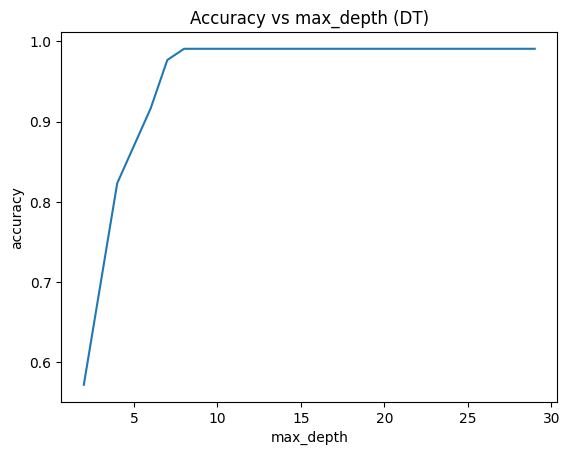

Max Accuracy at max_depth =  8.0


In [379]:
results = {'accuracy':[],\
            'max_depth':np.arange(2,30)}

for k in results['max_depth']:

    dt = DecisionTreeClassifier(max_depth=k, random_state=42)
    metrics_results = train_model(dt,X_train_scaled,y_train,X_test_scaled,y_test)
    results['accuracy'].append(metrics_results)

# dataframe for dt performance
results_df = pd.DataFrame(columns=['max_depth','accuracy'])
results_df['accuracy'] = results['accuracy']
results_df['max_depth'] = results['max_depth']
# plot performance for the algorithm
plot_performance(results_df, 'DT','max_depth')
k = getTopParameter(results_df, 'max_depth')
print('Max Accuracy at max_depth = ',k)

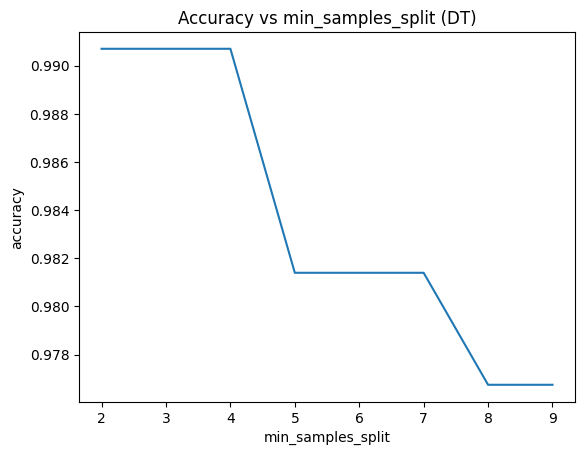

Max Accuracy at min_samples_split =  2.0


In [380]:
results = {'accuracy':[],\
            'min_samples_split':np.arange(2,10)}

for k in results['min_samples_split']:

    dt = DecisionTreeClassifier(min_samples_split=k, random_state=42)
    metrics_results = train_model(dt,X_train_scaled,y_train,X_test_scaled,y_test)
    results['accuracy'].append(metrics_results)

# dataframe for dt performance
results_df = pd.DataFrame(columns=['min_samples_split','accuracy'])
results_df['accuracy'] = results['accuracy']
results_df['min_samples_split'] = results['min_samples_split']
# plot performance for the algorithm
plot_performance(results_df, 'DT','min_samples_split')
k = getTopParameter(results_df, 'min_samples_split')
print('Max Accuracy at min_samples_split = ',k)

### Summary

- The min_samples_split and max_depth must be centered arond 2 and 8 for cross validation respectively

### Random Forest classifier performance evaluation on different values of hyperparameters

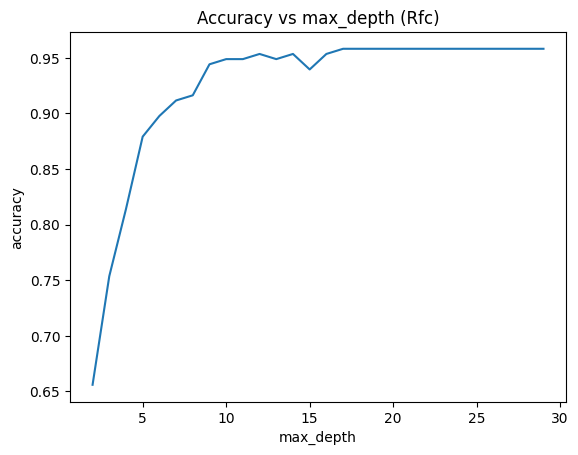

Max Accuracy at max_depth =  17.0


In [381]:
results = {'accuracy':[],\
            'max_depth':np.arange(2,30)}

for k in results['max_depth']:

    rfc = RandomForestClassifier(max_depth=k, random_state=42)
    metrics_results = train_model(rfc,X_train_scaled,y_train,X_test_scaled,y_test)
    results['accuracy'].append(metrics_results)

# dataframe for rfc performance
results_df = pd.DataFrame(columns=['max_depth','accuracy'])
results_df['accuracy'] = results['accuracy']
results_df['max_depth'] = results['max_depth']
plot_performance(results_df, 'Rfc','max_depth');
k = getTopParameter(results_df, 'max_depth')
print('Max Accuracy at max_depth = ',k)

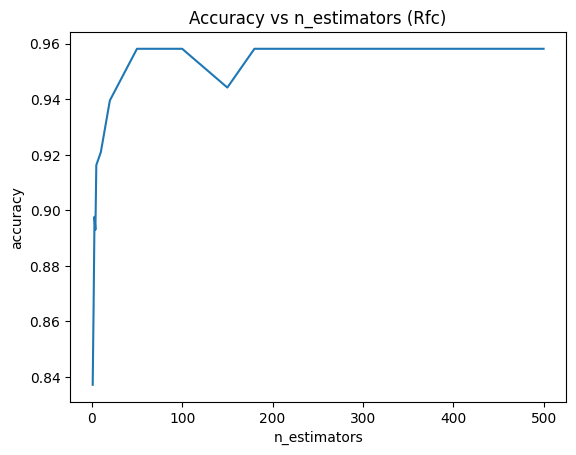

Max Accuracy at n_estimators =  50.0


In [382]:
results = {'accuracy':[],
            'n_estimators':[1, 2, 3, 4, 5, 10, 20, 50, 100, 150, 180, 200, 300, 500]}

for k in results['n_estimators']:

    rfc = RandomForestClassifier(n_estimators=k, random_state=42)
    metrics_results = train_model(rfc,X_train_scaled,y_train,X_test_scaled,y_test)
    results['accuracy'].append(metrics_results)

results_df = pd.DataFrame(columns=['n_estimators','accuracy'])
results_df['accuracy'] = results['accuracy']
results_df['n_estimators'] = results['n_estimators']
plot_performance(results_df, 'Rfc','n_estimators');
k = getTopParameter(results_df, 'n_estimators')
print('Max Accuracy at n_estimators = ',k)

#### Summary
- From the above plot and experiments, it is seen that grid of parameters should be centered for n_estimators at 50 and max_depth at 17 during cross validation.

### KNN Performance evaluation on different values of hyperparameters

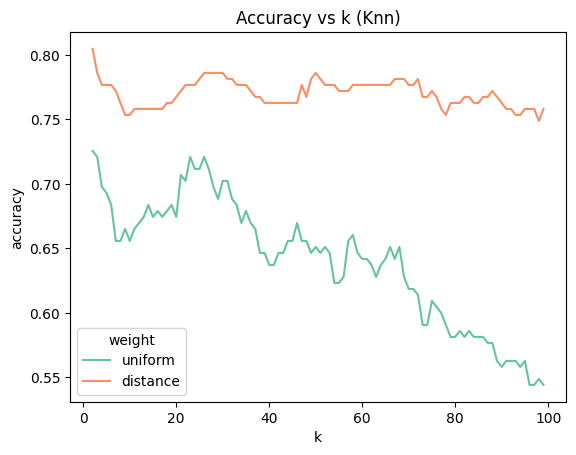

Max accuracy at n_neigbors (uniform) =  2
Max accuracy at n_neigbors (distance) =  2


In [383]:
results = {'distance':\
           {'accuracy':[]}, 'uniform':{'accuracy':[]}\
            ,'n_neighbors':np.arange(2,100) }

for k in results['n_neighbors']:

    # for uniform weighted KNN
    knn_uniform = KNeighborsClassifier(weights='uniform', n_neighbors=k)
    metrics_results = train_model(knn_uniform,X_train_scaled,y_train,X_test_scaled,y_test)
    results['uniform']['accuracy'].append(metrics_results)
    
    # for distance weighted KNN
    knn_distance = KNeighborsClassifier(weights='distance', n_neighbors=k)
    metrics_results = train_model(knn_distance,X_train_scaled,y_train,X_test_scaled,y_test)
    results['distance']['accuracy'].append(metrics_results)

# dataframe for uniform weighted knn
results_uniform_df = pd.DataFrame(columns=['k','weight'])
results_uniform_df['accuracy'] = results['uniform']['accuracy']
results_uniform_df['weight'] = 'uniform'
results_uniform_df['k'] = results['n_neighbors']

# dataframe for distance weighted knn 
results_distance_df = pd.DataFrame(columns=['k','weight'])
results_distance_df['accuracy'] = results['distance']['accuracy']
results_distance_df['weight'] = 'distance'
results_distance_df['k'] = results['n_neighbors']

# dataframe to concatenate both dataframes
results_df = pd.concat([results_uniform_df, results_distance_df],axis=0)
plot_performance(results_df, 'Knn','k','weight')

# finding n_neighbors where the accuracy is the highest 
k = getTopParameter(results_uniform_df, 'k')
print('Max accuracy at n_neigbors (uniform) = ',k)

k = getTopParameter(results_distance_df, 'k')
print('Max accuracy at n_neigbors (distance) = ',k)

#### Summary

- KNN grid of parameters are to be centered at n_neighbors = 2 for both uniform and distance weights. 

### Nested Cross Validation

- Nested Cross validation is used to find best hyperparameters and also select the best model for a given dataset
- Use of inner and outer cv would find the best hyperparmeters by fitting the model with one dataset and evaluating in another dataset that is never seen directly or indirectly during model fit
- This helps to determine model's overall capability over different sets of data

In [384]:
# num of trials for nested cv
NUM_TRIALS = 3
# number of splits in inner cv
NUM_INNER_SPLITS=3 
# number of splits in outer cv
NUM_OUTER_SPLITS=3
# performance metrics
PERF_METRICS = ['balanced_accuracy']

In [385]:
# metrics based on which the comparison of all algorithms would be done
METRICS = ['name','acc_min','acc_max','acc_mean','acc_std',\
                    'fit_time(avg)','test_time(avg)']

In [386]:
# reference from the Machine Learning lecture
def run_nested_cv(estimator, grid_params, x, y):
    """
       This function accepts machine learning model, grid of parameters for the model, features and target variables as arguments.
       Inner and outer cv are run using the machine learning model and are evaluated on different metrics and parameters 
       Function returns performance results after fitting the model 
    """
    accs = np.zeros((NUM_TRIALS, NUM_OUTER_SPLITS))
    fit_times= np.zeros((NUM_TRIALS, NUM_OUTER_SPLITS))
    test_times=np.zeros((NUM_TRIALS, NUM_OUTER_SPLITS))
    start = time.time()

    for i in range(NUM_TRIALS):
        print("Running Outer CV in iteration: ", i, " at ", time.time()-start, "s")
        # inner cv
        inner_cv = RepeatedStratifiedKFold(n_splits=NUM_INNER_SPLITS, random_state=i)
        # outer cv
        outer_cv = StratifiedKFold(n_splits=NUM_OUTER_SPLITS, shuffle=True, random_state=i)
        # grid_searchcv
        # refit on accuracy
        model = GridSearchCV(estimator=estimator, param_grid=grid_params, cv=inner_cv, scoring=PERF_METRICS, n_jobs=-1, refit="balanced_accuracy")
        model_results = cross_validate(model, X=x, y=y, cv=outer_cv, scoring=PERF_METRICS, n_jobs=-1)

        accs[i] = model_results["test_balanced_accuracy"]
        fit_times[i] = model_results['fit_time']
        test_times[i] = model_results['score_time']
    
    print ("Total time: ", (time.time()-start),  "s")
    return  accs, fit_times, test_times

In [387]:
def concatenate_evaluation_metrics(dframe, name, accs, fit_times, test_times):
    """
       The function accepts pandas dataframe with previous performance results, model name, accuracy, training and test times
       as arguments.
       The function returns updated dataframe of performance results
    """
    
    data = [name, accs.min(), accs.max(), accs.mean(), accs.std(),\
            fit_times.mean(),test_times.mean()]
    
    new_dframe = pd.DataFrame(data=[data],columns=METRICS)
    
    return pd.concat([dframe, new_dframe], ignore_index=True, axis=0)

In [392]:
# dataframe for showing performance results for all algorithms
nested_cv_results_df = pd.DataFrame(columns=METRICS)

### Decision Tree Nested CV

In [393]:
grid_params = {'max_depth':np.arange(5,12), 'min_samples_split':np.arange(2,7),'criterion':('gini','entropy')}
dt = DecisionTreeClassifier(random_state=42)
accs, fit_times, test_times = run_nested_cv(dt, grid_params, X_train_scaled, y_train)
nested_cv_results_df = concatenate_evaluation_metrics(nested_cv_results_df, "DT", accs, fit_times, test_times)

nested_cv_results_df

Running Outer CV in iteration:  0  at  4.76837158203125e-06 s
Running Outer CV in iteration:  1  at  22.696157932281494 s
Running Outer CV in iteration:  2  at  42.04373359680176 s
Total time:  69.42572450637817 s


,name,acc_min,acc_max,acc_mean,acc_std,fit_time(avg),test_time(avg)
0,DT,0.972469,0.997126,0.983563,0.009359,23.079099,0.003577


### KNN Nested CV

In [395]:
grid_params = {"weights": ['uniform', 'distance'],"n_neighbors": range(2,8)}
knn = KNeighborsClassifier()
accs, fit_times, test_times = run_nested_cv(knn, grid_params, X_train_scaled, y_train)
nested_cv_results_df = concatenate_evaluation_metrics(nested_cv_results_df, "KNN", accs, fit_times, test_times)

nested_cv_results_df

Running Outer CV in iteration:  0  at  1.430511474609375e-06 s
Running Outer CV in iteration:  1  at  10.630740880966187 s
Running Outer CV in iteration:  2  at  20.572248697280884 s
Total time:  30.1011004447937 s


,name,acc_min,acc_max,acc_mean,acc_std,fit_time(avg),test_time(avg)
0,DT,0.972469,0.997126,0.983563,0.009359,23.079099,0.003577
1,KNN,0.690408,0.760614,0.731844,0.022840,9.943714,0.007659


### Random Forest Nested CV

In [396]:
grid_params = {
     'max_depth':np.arange(13,22),
     'n_estimators':np.arange(46,55),
     'criterion':['gini','entropy']
}
rfc = RandomForestClassifier()
accs, fit_times, test_times = run_nested_cv(rfc, grid_params, X_train_scaled, y_train)
nested_cv_results_df = concatenate_evaluation_metrics(nested_cv_results_df, "RFC", accs, fit_times, test_times)

nested_cv_results_df

Running Outer CV in iteration:  0  at  1.1920928955078125e-06 s
Running Outer CV in iteration:  1  at  839.1954982280731 s
Running Outer CV in iteration:  2  at  1562.7129609584808 s
Total time:  2292.1472063064575 s


,name,acc_min,acc_max,acc_mean,acc_std,fit_time(avg),test_time(avg)
0,DT,0.972469,0.997126,0.983563,0.009359,23.079099,0.003577
1,KNN,0.690408,0.760614,0.731844,0.022840,9.943714,0.007659
2,RFC,0.907245,0.945061,0.926118,0.013317,762.741248,0.008850


### Summary

- From the above nested cv experiements and results, we can observe that Decision Tree Classifier is the best in terms of accuracy.
- But we still need to evaluate its performance on test data (scaled).

### Saving the winner model (Decision Tree Classifier with best hyperparameters)

In [397]:
grid_params = {'max_depth':np.arange(5,12), 'min_samples_split':np.arange(2,7),'criterion':('gini','entropy')}
final_dt = DecisionTreeClassifier(random_state=42)

outer_cv = KFold(n_splits=NUM_INNER_SPLITS)
final_model = GridSearchCV(estimator=final_dt, param_grid=grid_params, cv=outer_cv, scoring=PERF_METRICS, n_jobs=-1, refit="balanced_accuracy")

final_model.fit(X_train_scaled,y_train) 

print('Hypertuned parameters = \n', final_model.best_params_)

Hypertuned parameters = 
 {'criterion': 'entropy', 'max_depth': 11, 'min_samples_split': 2}


#### Prediction on test dataset using XGBoost hypertuned model

In [398]:
pred = final_model.predict(X_test_scaled)

balanced_accuracy_score(pred,y_test)

0.9889705882352942

In [399]:
### saving the model
try:
    joblib.dump(final_model,'model.joblib')
    print('Model saved succesfully')
except Exception as e:
    print('Error saving model')
    print(e)


Model saved succesfully


### Conclusion

- The performance of tree-based models like Decision Tree and Random Forest seems to be too good to be true. However, it is not something very unusual. At the initial preprocessing steps, we assumed two main conditions for creating our target data using the email address.
- The email domain names and digits were used for categorizing the email address to certain age group.
- Therefore, these simple assumptions are something to obvious to decision tree classifier that it performs so well.
- Having said, the winner model no where simulates the production level machine learning model.
- But, if the new unseen real-world data follows similar patterns that we have assumed then the winner model will certainly be a great choice.